# Mustererkennung/Machine Learning - Assignment 6



In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from collections import defaultdict
import matplotlib.pyplot as plt

Load the spam dataset:

In [4]:
data = np.array(pd.read_csv('spambase.data', header=None))

X = data[:,:-1] # features
y = data[:,-1] # Last column is label

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True, stratify=y)


## Exercise 1

Implement a classification tree using python (incl. Numpy etc.) and use it on the SPAM-Dataset. Use a metric of your choice as a loss function.

(Implementation inspired by:
https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/ )


In [5]:
X.shape

(4601, 57)

In [6]:
X_train.shape, X_test.shape

((3450, 57), (1151, 57))

In [7]:
y_train.shape, y_test.shape

((3450,), (1151,))

**Possible modifications/improvements:**

1. Another possible stopping criterion: until all leaves are pure


2. Pruning to correct the depth that was added due to balance criterion: in case a node was split into a very unbalanced distribution where one child node contains no points and the other child contains all, then this split could be removed in postprocessing and the parent node can be made leaf

    => With my code it can happen that two (or more?) subsequent node levels test the same variable and value and assign the same labels to both sides...either bug fix or prune. I implemented a pruning protocol that summarizes nodes with leaves of the same class label into a leaf. Comparing the test set performace resulted in around 91.57% accuracy for both the unpruned (depth 411) and pruned tree (depth 299).
    
    
3. Does the gini index need to be additionally weighted by group proportions?



4. Training on the complete data takes around 3-4 minutes

In [14]:
class ClassificationTree():


    def __init__(self, node_min_size=2, tree_max_depth=None, post_pruning=True):
        """
        If no maximum depth is defined, the nodes are split while they contain at least node_min_size many points.
        If maximum depth is defined, nodes are split further until they contain less than node_min_size many points or
        have reached the maximum number of allowed split levels.
        """
        self.depth = 1
        self.node_min_size = node_min_size
        self.tree_max_depth = tree_max_depth
        self.prune = 0
        self.post_pruning = post_pruning
        self.feature_importances = defaultdict(int)
        
    ################ Tree building ################
    
    def split_data(self, X, j, v):
        """
        Split data X at variable with index j and splitting point v.
        """
        split_left = X[np.where(X[:,j]<=v)]
        split_right = X[np.where(X[:,j]>v)]
        return split_left, split_right

    
    def gini_index(self, groups):
        """
        Calculate gini index for a data set splitted on a certain variable and splitting point.
        groups: two subsets that result from splitting a data set
        y: associated class labels
        """
        gini = 0
        if type(groups[0]) == np.ndarray:
            n = sum(map(len,groups))
            # get class proportions for each split group
            for group in groups:
                size = float(len(group))
                y = group[:,-1]
                if size == 0:
                    continue    
                score = 0
                # sum class proportions within one split groups as sum(p_mk*(1-p_mk))
                for c in set(y):
                    proportions = np.count_nonzero(y==c)/size
                    score += proportions*(1-proportions)
                # sum "inversely squared" class proportions per split group in weighted sum (weighted by proportion of group size)
                gini += score * size/n
        else:
            size = len(groups)
            for c in set(groups):
                proportions = groups.count(c)/size
                gini += proportions*(1-proportions)
        return gini


    def split_node(self, data):
        """
        Find optimal split for a given node "node" and class labels "y" that minimizes the loss function (gini index).
        """
        split_var, split_point, split_gini, groups = 9999, 9999, 9999, None
        # for every candidate split X*p* calculate gini index and select split which minimizes the score
        for j in range(data.shape[1]-1):
            candidate_p = np.unique(X[:,j])
            for v in candidate_p:
                split_groups = self.split_data(data, j, v)
                s = self.gini_index(split_groups) 
                if s < split_gini: 
                    split_var, split_point, split_gini, groups = j, v, s, split_groups
        return {'split_var': split_var, 'split_point': split_point, 'split_gini': split_gini, 'groups': groups}


    def make_leaf(self, node_labels):
        """
        Convert node "node" to leaf by assigning it the majority vote of labels "y".
        """
        leaf_labels = list(node_labels)
        return {'label': max(set(leaf_labels), key=leaf_labels.count), 'class_sizes': [leaf_labels.count(c) for c in set(leaf_labels)]} 

    
    def grow(self, node):
        """
        Recusively split nodes until stopping criteria are fulfilled,
        i.e. a node has too little data points in its region to be splitted further or the the has
        reached its maximum allowd depth.
        """
        left, right = node['groups']
        del(node['groups'])
        # Check for empty nodes (pruned in post-processing)
        if not left.any() or not right.any():
            node['left'] = node['right'] = self.make_leaf(np.r_[left[:,-1], right[:,-1]])
            return None
        # Check for max depth
        if self.tree_max_depth:
            if self.depth >= self.tree_max_depth:
                node['left'] = self.make_leaf(left[:,-1])
                node['right'] = self.make_leaf(right[:,-1])
                return None
        # Check left node size
        if len(left) <= self.node_min_size-1:
            node['left'] = self.make_leaf(left[:,-1])
        else:
            node['left'] = self.split_node(left)
            self.depth += 1
            self.grow(node['left'])
        # Check right node size
        if len(right) <= self.node_min_size:
            node['right'] = self.make_leaf(right[:,-1])
        else:
            node['right'] = self.split_node(right)
            self.depth += 1
            self.grow(node['right'])
        return None
    
    ################ Post-Pruning ################
    
    def check_twin_leaves(self, subtree):
        """
        Prune tree while there still are twin leaves
        """
        if not 'label' in subtree.keys():  
            if 'label' in subtree['left'].keys() and 'label' in subtree['right'].keys():
                if subtree['left']['label'] == subtree['right']['label']:
                    self.prune += 1
            else:
                self.check_twin_leaves(subtree['left'])
                self.check_twin_leaves(subtree['right'])

    def prune_tree(self, subtree):
        """
        If a node results in leaves of the same label, remove leaves and make node to leaf
        """
        # check if A is node or leaf
        if not 'label' in subtree.keys():  
            # at least one subtree B1, B2 has to be a node
            if not 'label' in subtree['left'].keys() or not 'label' in subtree['right'].keys():
                # prune left subtree B1?
                if not 'label' in subtree['left'].keys():
                    tmp = subtree['left']
                    # check if node has two leaves
                    if 'label' in tmp['left'] and 'label' in tmp['right']:
                        if tmp['left']['label'] == tmp['right']['label'] :
                            subtree['left'] = {'label': tmp['left']['label'], 'class_sizes':list(map(sum,list(zip(tmp['left']['class_sizes'],tmp['right']['class_sizes']))))}
                            self.prune -= 1
                            # if B2 is a leaf, decrement depth
                            if 'label' in subtree['right'].keys():
                                self.depth -= 1
                    else:
                        self.prune_tree(tmp)
                # prune right subtree B2?           
                if not 'label' in subtree['right'].keys():
                    tmp = subtree['right']
                    # check if node has two leaves
                    if 'label' in tmp['left'] and 'label' in tmp['right']:
                        if tmp['left']['label'] == tmp['right']['label'] :
                            subtree['right'] = {'label': tmp['left']['label'], 'class_sizes':list(map(sum,list(zip(tmp['left']['class_sizes'],tmp['right']['class_sizes']))))}
                            self.prune -= 1
                            # if B2 is a leaf, decrement depth
                            if 'label' in subtree['left'].keys():
                                self.depth -= 1
                    else:
                        self.prune_tree(tmp)

    ################ Build tree from data  ################
    
    def grow_tree(self, X, y):
        """
        Grow a decision tree for feature data X with class labels y that has at most tree_max_depth many levels
        and at least node_mins_size many data points that support each leaf prediction.
        """
        print('Build tree from data')
        if X.shape[0] <= self.node_min_size:
            raise Exception("Data set is too small to build a tree!")
        root = self.split_node(np.c_[X,y])
        self.grow(root)
        if self.post_pruning:
            print('Post-pruning')
            self.check_twin_leaves(root)
            while self.prune >= 1:
                self.prune_tree(root)
                self.check_twin_leaves(root)
        print('Feature importances')
        for i in range(X.shape[1]):
            self.get_feature_importance(root,i)
        f = float(sum(self.feature_importances.values()))
        for k,v in self.feature_importances.items():
            self.feature_importances[k] = v/f
        return root   
            
    ################ Classification ################
    
    def get_label(self, test, subtree):
        """
        Process data query through the decision tree and retrieve resulting leaf label.
        """
        if not 'label' in subtree.keys():
            if test[subtree['split_var']] <= subtree['split_point']:
                subtree = subtree['left']
                return self.get_label(test, subtree)
            else:
                subtree = subtree['right']
                return self.get_label(test, subtree)
        else:
            return subtree['label']
        
        
    def predict(self, tree, X):
        """
        Predict class labels for data set X.
        """
        y_pred = []
        for item in X:
            y_pred.append(self.get_label(item, tree))
        return y_pred
    
    ################ Evaluation ################
    
    def calculate_accuracy(self, true_y, pred_y, classes):
        """
        Calculate accuracy for a classified set.
        """
        class_sum = 0
        for class_num in classes:
            val_sum = 0
            for true_val, pred_val in zip(true_y, pred_y): 
                if class_num == true_val:
                    if true_val == pred_val:
                        val_sum += 1
            class_sum += val_sum
        return class_sum / len(true_y)
    
    
    # TODO: weight scores by probability to reach respective node, i.e. node size/data size
    def get_feature_importance(self, subtree, var):
        """
        """
        if not 'label' in subtree.keys():
            if subtree['split_var'] == var:
                if 'class_sizes' in subtree['left'].keys():
                    ginil = self.gini_index(subtree['left']['class_sizes'])
                else: 
                    ginil = subtree['left']['split_gini']
                if 'class_sizes' in subtree['right'].keys():
                    ginir = self.gini_index(subtree['right']['class_sizes'])
                else:
                    ginir = subtree['right']['split_gini']
                self.feature_importances[var] += subtree['split_var']-(ginir+ginil)

            self.get_feature_importance(subtree['left'], var)
            self.get_feature_importance(subtree['right'], var)


In [15]:
CT_pruned = ClassificationTree()
#CT_unpruned = ClassificationTree(post_pruning=False)

In [16]:
tree_pruned = CT_pruned.grow_tree(X_train[:100,:], y_train[:100])
#tree_unpruned = CT_unpruned.grow_tree(X_train[:50,:], y_train[:50])

Build tree from data
Post-pruning
Feature importances


In [ ]:
CT_pruned.depth#, CT_unpruned.depth

In [ ]:
y_pred_pruned = CT_pruned.predict(tree_pruned, X_test[:50])
#y_pred_unpruned = CT_unpruned.predict(tree_unpruned, X_test)

In [ ]:
acc_pruned = 100*CT_pruned.calculate_accuracy(y_test[:50], y_pred_pruned, set(y_test))
#acc_unpruned = 100*CT_unpruned.calculate_accuracy(y_test, y_pred_unpruned, set(y_test))

In [ ]:
print("The trained pruned classification tree yields an accuracy of {}% on the test set".format(round(acc_pruned,2)))
#print("The trained unpruned classification tree yields an accuracy of {}% on the test set".format(round(acc_unpruned,2)))

**Exercise 1.a**

Assume that classifying a genuine E-Mail as spam is ten times worse than classifying spam as genuine. How yould you change the design of your decision tree?


(Eva): 
<br>Should we only answer or also implement here? My idea would be to use the misclassification error as loss function and to implement this penalty as a weighting scheme. <br> E.g. when calculating the misclassification error for a split, one node would have the maximum p_m,k for k=0 (real mail) and the other node would have maximum p_m,k for k=1 (spam). Then, the misclassification error for the p_m,0-node could be weighted with w_fp (weight for false positives) and the p_m,1.node could be weighted with w_fn (false negative weight) where w_fn = 10 * w_fp.
Of course a similar weighting could be implemented into the gini scoring function.

**Exercise 1.b**

Use your tree to analyze feature importance. Plot the difference between the top 5 features (check spambase.names to check what features those belong to).

In [73]:
feature_importances = CT_pruned.feature_importances
sorted_feature_importances = list(zip(*sorted(feature_importances.items(), key= lambda x: x[1])))

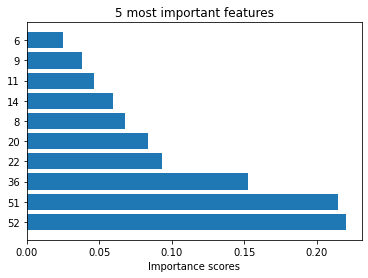

In [74]:
features = sorted_feature_importances[0]
importance = sorted_feature_importances[1]
pos = np.arange(len(features))

fig, ax = plt.subplots()
ax.barh(pos, importance)
ax.set_yticks(pos)
ax.set_yticklabels(features) #TODO: add real variable names
ax.invert_yaxis() 
ax.set_xlabel('Importance scores')
ax.set_title('5 most important features')
plt.show()

# Exercise 2. Random Forests
Implement a Random Forest and use it on the SPAM-Dataset.

### Here, the Tree Building algorithm is exactly the same as before, except for the split node function. Instead of looping over all possible Xj of length N, we now only loop over a random subset of the Xj of length sqrt(N).
Also the accuracy function was moved from the Classification Tree Object to outside of the objects, to avoid trying to access a class member fuction inside a class.

In [61]:
class RandomForest:
    def __init__(self):
        self.trees = None
        
    class ClassificationTreeRF:
        
        def __init__(self, node_min_size=2, tree_max_depth=None, post_pruning=True):
            """
            If no maximum depth is defined, the nodes are split while they contain at least node_min_size many points.
            If maximum depth is defined, nodes are split further until they contain less than node_min_size many points or
            have reached the maximum number of allowed split levels.
            """
            self.depth = 1
            self.node_min_size = node_min_size
            self.tree_max_depth = tree_max_depth
            self.prune = 0
            self.post_pruning = post_pruning
            self.feature_importances = defaultdict(int)

        ################ Tree building ################

        def split_data(self, X, j, v):
            """
            Split data X at variable with index j and splitting point v.
            """
            split_left = X[np.where(X[:,j]<=v)]
            split_right = X[np.where(X[:,j]>v)]
            return split_left, split_right


        def gini_index(self, groups):
            """
            Calculate gini index for a data set splitted on a certain variable and splitting point.
            groups: two subsets that result from splitting a data set
            y: associated class labels
            """
            gini = 0
            if type(groups[0]) == np.ndarray:
                n = sum(map(len,groups))
                # get class proportions for each split group
                for group in groups:
                    size = float(len(group))
                    y = group[:,-1]
                    if size == 0:
                        continue    
                    score = 0
                    # sum class proportions within one split groups as sum(p_mk*(1-p_mk))
                    for c in set(y):
                        proportions = np.count_nonzero(y==c)/size
                        score += proportions*(1-proportions)
                    # sum "inversely squared" class proportions per split group in weighted sum (weighted by proportion of group size)
                    gini += score * size/n
            else:
                size = len(groups)
                for c in set(groups):
                    proportions = groups.count(c)/size
                    gini += proportions*(1-proportions)
            return gini


        def split_node(self, data):
            """
            Find optimal split for a given node "node" and class labels "y" that minimizes the loss function (gini index).
            Additionally for Random Forest, only a subset (sqrt(N)) of features is tested.
            """
            split_var, split_point, split_gini, groups = 9999, 9999, 9999, None
            # for selected candidates split X*p* calculate gini index and select split which minimizes the score
            random_candidates = np.random.randint(data.shape[1]-1, size=int(np.sqrt(data.shape[1])))
            for j in random_candidates:
                candidate_p = np.unique(X[:,j])
                for v in candidate_p:
                    split_groups = self.split_data(data, j, v)
                    s = self.gini_index(split_groups) 
                    if s < split_gini: 
                        split_var, split_point, split_gini, groups = j, v, s, split_groups
            return {'split_var': split_var, 'split_point': split_point, 'split_gini': split_gini, 'groups': groups}


        def make_leaf(self, node_labels):
            """
            Convert node "node" to leaf by assigning it the majority vote of labels "y".
            """
            leaf_labels = list(node_labels)
            return {'label': max(set(leaf_labels), key=leaf_labels.count), 'class_sizes': [leaf_labels.count(c) for c in set(leaf_labels)]} 


        def grow(self, node):
            """
            Recusively split nodes until stopping criteria are fulfilled,
            i.e. a node has too little data points in its region to be splitted further or the the has
            reached its maximum allowd depth.
            """
            left, right = node['groups']
            del(node['groups'])
            # Check for empty nodes (pruned in post-processing)
            if not left.any() or not right.any():
                node['left'] = node['right'] = self.make_leaf(np.r_[left[:,-1], right[:,-1]])
                return None
            # Check for max depth
            if self.tree_max_depth:
                if self.depth >= self.tree_max_depth:
                    node['left'] = self.make_leaf(left[:,-1])
                    node['right'] = self.make_leaf(right[:,-1])
                    return None
            # Check left node size
            if len(left) <= self.node_min_size-1:
                node['left'] = self.make_leaf(left[:,-1])
            else:
                node['left'] = self.split_node(left)
                self.depth += 1
                self.grow(node['left'])
            # Check right node size
            if len(right) <= self.node_min_size:
                node['right'] = self.make_leaf(right[:,-1])
            else:
                node['right'] = self.split_node(right)
                self.depth += 1
                self.grow(node['right'])
            return None

        ################ Post-Pruning ################

        def check_twin_leaves(self, subtree):
            """
            Prune tree while there still are twin leaves
            """
            if not 'label' in subtree.keys():  
                if 'label' in subtree['left'].keys() and 'label' in subtree['right'].keys():
                    if subtree['left']['label'] == subtree['right']['label']:
                        self.prune += 1
                else:
                    self.check_twin_leaves(subtree['left'])
                    self.check_twin_leaves(subtree['right'])

        def prune_tree(self, subtree):
            """
            If a node results in leaves of the same label, remove leaves and make node to leaf
            """
            # check if A is node or leaf
            if not 'label' in subtree.keys():  
                # at least one subtree B1, B2 has to be a node
                if not 'label' in subtree['left'].keys() or not 'label' in subtree['right'].keys():
                    # prune left subtree B1?
                    if not 'label' in subtree['left'].keys():
                        tmp = subtree['left']
                        # check if node has two leaves
                        if 'label' in tmp['left'] and 'label' in tmp['right']:
                            if tmp['left']['label'] == tmp['right']['label'] :
                                subtree['left'] = {'label': tmp['left']['label'], 'class_sizes':list(map(sum,list(zip(tmp['left']['class_sizes'],tmp['right']['class_sizes']))))}
                                self.prune -= 1
                                # if B2 is a leaf, decrement depth
                                if 'label' in subtree['right'].keys():
                                    self.depth -= 1
                        else:
                            self.prune_tree(tmp)
                    # prune right subtree B2?           
                    if not 'label' in subtree['right'].keys():
                        tmp = subtree['right']
                        # check if node has two leaves
                        if 'label' in tmp['left'] and 'label' in tmp['right']:
                            if tmp['left']['label'] == tmp['right']['label'] :
                                subtree['right'] = {'label': tmp['left']['label'], 'class_sizes':list(map(sum,list(zip(tmp['left']['class_sizes'],tmp['right']['class_sizes']))))}
                                self.prune -= 1
                                # if B2 is a leaf, decrement depth
                                if 'label' in subtree['left'].keys():
                                    self.depth -= 1
                        else:
                            self.prune_tree(tmp)

        ################ Build tree from data  ################

        def grow_tree(self, X, y):
            """
            Grow a decision tree for feature data X with class labels y that has at most tree_max_depth many levels
            and at least node_mins_size many data points that support each leaf prediction.
            """
            print('Build tree from data')
            if X.shape[0] <= self.node_min_size:
                raise Exception("Data set is too small to build a tree!")
            root = self.split_node(np.c_[X,y])
            self.grow(root)
            if self.post_pruning:
                print('Post-pruning')
                self.check_twin_leaves(root)
                while self.prune >= 1:
                    self.prune_tree(root)
                    self.check_twin_leaves(root)
            print('Feature importances')
            for i in range(X.shape[1]):
                self.get_feature_importance(root,i)
            f = float(sum(self.feature_importances.values()))
            for k,v in self.feature_importances.items():
                self.feature_importances[k] = v/f
            return root   

        ################ Classification ################

        def get_label(self, test, subtree):
            """
            Process data query through the decision tree and retrieve resulting leaf label.
            """
            if not 'label' in subtree.keys():
                if test[subtree['split_var']] <= subtree['split_point']:
                    subtree = subtree['left']
                    return self.get_label(test, subtree)
                else:
                    subtree = subtree['right']
                    return self.get_label(test, subtree)
            else:
                return subtree['label']


        def predict(self, tree, X):
            """
            Predict class labels for data set X.
            """
            y_pred = []
            for item in X:
                y_pred.append(self.get_label(item, tree))
            return y_pred

        ################ Evaluation ################

        # TODO: weight scores by probability to reach respective node, i.e. node size/data size
        def get_feature_importance(self, subtree, var):
            """
            """
            if not 'label' in subtree.keys():
                if subtree['split_var'] == var:
                    if 'class_sizes' in subtree['left'].keys():
                        ginil = self.gini_index(subtree['left']['class_sizes'])
                    else: 
                        ginil = subtree['left']['split_gini']
                    if 'class_sizes' in subtree['right'].keys():
                        ginir = self.gini_index(subtree['right']['class_sizes'])
                    else:
                        ginir = subtree['right']['split_gini']
                    self.feature_importances[var] += subtree['split_var']-(ginir+ginil)

                self.get_feature_importance(subtree['left'], var)
                self.get_feature_importance(subtree['right'], var)
    
    ###################################################################
    #################  Random Forest Functions  #######################
    ###################################################################
    
    def fitRF(self, X_train, y_train, num_bags, bag_size):
        """
        This Function creates a specified number of bags and trees and stores the trees in self.trees.
        """
        X_bags = []
        Y_bags = []
        for bag_i in range(num_bags):
            indices = np.random.randint(X_train.shape[0], size=bag_size)
            X_bags.append(X_train[indices,:])
            Y_bags.append(y_train[indices])
        
        self.trees = []
        for i, (X_bags_i, Y_bags_i) in enumerate(zip(X_bags, Y_bags)):
            print("--------------------------")
            print("Train Tree i =", i)
            self.trees.append(self.ClassificationTreeRF().grow_tree(X_bags_i, Y_bags_i))
        print("--------------------------")
        
    def predictRF(self, X_test):
        """
        This Function predicts a label for a given test set for all trees, 
        then the majority vote of all trees is chosen as the label.
        """
        if not self.trees is None:
            y_pred_per_tree = np.array([self.ClassificationTreeRF().predict(tree, X_test) for tree in self.trees]).T
            #print(y_pred_per_tree)
            return np.array([np.argmax(np.bincount(xi.astype(int))) for xi in y_pred_per_tree]).astype(float)
        else:
            return None

def calculate_accuracy(true_y, pred_y, classes):
            """
            Calculate accuracy for a classified set.
            """
            class_sum = 0
            for class_num in classes:
                val_sum = 0
                for true_val, pred_val in zip(true_y, pred_y): 
                    if class_num == true_val:
                        if true_val == pred_val:
                            val_sum += 1
                class_sum += val_sum
            return class_sum / len(true_y)

In [62]:
RF = RandomForest()
num_bags = 5
bag_size = int(X_train.shape[0] * 0.75)
RF.fitRF(X_train, y_train, num_bags, bag_size)

--------------------------
Train Tree i = 0
Build tree from data
Post-pruning
Feature importances
--------------------------
Train Tree i = 1
Build tree from data
Post-pruning
Feature importances
--------------------------
Train Tree i = 2
Build tree from data
Post-pruning
Feature importances
--------------------------
Train Tree i = 3
Build tree from data
Post-pruning
Feature importances
--------------------------
Train Tree i = 4
Build tree from data
Post-pruning
Feature importances
--------------------------


In [63]:
y_pred = RF.predictRF(X_test)
y_pred

array([0., 0., 0., ..., 0., 1., 0.])

In [64]:
calculate_accuracy(y_test, y_pred, np.unique(y_test))

0.9539530842745438

## (a) Print a confusion matrix (you can use package implementations here).
Here we used a function we already wrote in week 4 to display the confusion matrix.

In [37]:
def calculate_confusion_matrix(y_pred, y_true, class_label_list):
    """
    Returns a confusion matrix (ndarray) for all class labels given in class_label_list.
    The order of class_label_list is preserved.
    The first returned dimension(rows) are the predicted labels, the second one(columns) are the true labels.
    """
    confusion_matrix = []
    for class_label_pred in class_label_list:
        class_row = []
        for class_label_true in class_label_list:
            bool_pred = (y_pred == class_label_pred)
            bool_true = (y_true == class_label_true)
            occurrences = np.sum(np.logical_and(bool_pred, bool_true))
            class_row.append(occurrences)
        confusion_matrix.append(class_row)
    return np.array(confusion_matrix)

def display_confusion_matrix(y_pred, y_true, class_label_list):
    """Returns a labeled pandas DataFrame made from a confusion matrix (ndarray)"""
    confusion_matrix = calculate_confusion_matrix(y_pred, y_true, class_label_list)
    pred_labels = ["pred: " + str(x) for x in class_label_list]
    true_labels = ["true: " + str(x) for x in class_label_list]
    return pd.DataFrame(confusion_matrix, index=pred_labels, columns=true_labels)

In [72]:
display_confusion_matrix(y_pred, y_test, np.unique(y_test))

,true: 0.0,true: 1.0
pred: 0.0,669,25
pred: 1.0,28,429


## (b) What is a good number of trees in the forest?
We try out different numbers of bags/trees, initially from 2-20 (but that takes quite a while, so reducing it to a smaller interval also works)

In [70]:
%%capture
num_bags_list = np.arange(2,21) #<- change it for a shorter runtime
bag_size2 = int(X_train.shape[0] * 0.75)
accuracies = []
for num_bags2 in num_bags_list:
    RF = RandomForest()
    RF.fitRF(X_train, y_train, num_bags2, bag_size2)
    y_pred2 = RF.predictRF(X_test)
    accuracies.append(calculate_accuracy(y_test, y_pred2, np.unique(y_test)))

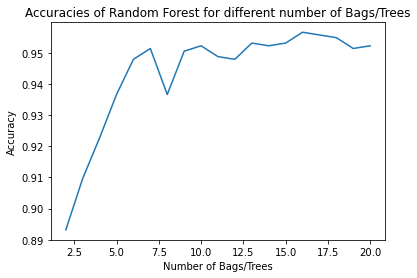

In [71]:
plt.plot(num_bags_list, accuracies)
plt.xlabel("Number of Bags/Trees")
plt.ylabel("Accuracy")
plt.title("Accuracies of Random Forest for different number of Bags/Trees")
plt.show()

### Result:
Seems like 16 is the best number of bags/trees